In [12]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random

In [13]:
def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    return img 

def circle_crop_v2(img):
    """
    Create circular crop around image centre
    """
    img = crop_image_from_gray(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)

    return img

In [14]:
IMG_SIZE = 224

def just_crop(img_path):
    img = circle_crop_v2(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.addWeighted(img,4, cv2.GaussianBlur(img, (0,0) , IMG_SIZE/10) ,-4 ,128) 
    return img

def load_ben_color(path, sigmaX=30):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    image = circle_crop_v2(image)
        
    return image

def final_pre(img, sigmaX=30):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess(img):
    #return final_pre(img)
    return load_ben_color(img)
    return just_crop(img)

In [24]:
def scaleRadius(img ,scale):
    print(img.shape)
    x = img[img.shape[0]//2,:,:].sum(1)
    r = (x>x.mean()/10).sum()/2
    s = scale*1.0/r
    return cv2.resize(img,(0,0),fx=s, fy=s)

def ben_preprocess(img):
    scale = 300
    a=cv2.imread(img)
    #s c a l e img t o a gi v e n r a di u s
    a=scaleRadius(a,scale)
    #s u b t r a c t l o c a l mean c o l o r
    a=cv2.addWeighted(a,4,cv2.GaussianBlur(a,(0,0) , scale/30) , -4 ,128)
    b=np.zeros(a.shape)
    cv2.circle(b,(a.shape[1]/2, a.shape[0]/2),int(scale*0.9),(1,1,1),1,8,0)
    a=a*b+128*(1-b)
    return a


In [16]:
DIR_ORIGIN = "Data/Resized/organized_2019/"
DIR_TARGET = "Data/Resized/preprocessed_2019_ben_color/"

directories = ["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]

for directory in directories:
    files = os.listdir(DIR_ORIGIN + directory)
    os.makedirs(DIR_TARGET + directory, exist_ok=True)
    for i, file in enumerate(files):
        print("Processing " + str(i) + " / " + str(len(files)) + f" {directory}", end='\r')
        img = ben_preprocess(DIR_ORIGIN + directory + "/" + file)
        cv2.imwrite(DIR_TARGET + directory + "/" + os.path.basename(file), img)
    print("Done " + directory)

(224, 224, 3)/ 370 Mild


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type


(224, 224, 3)


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type


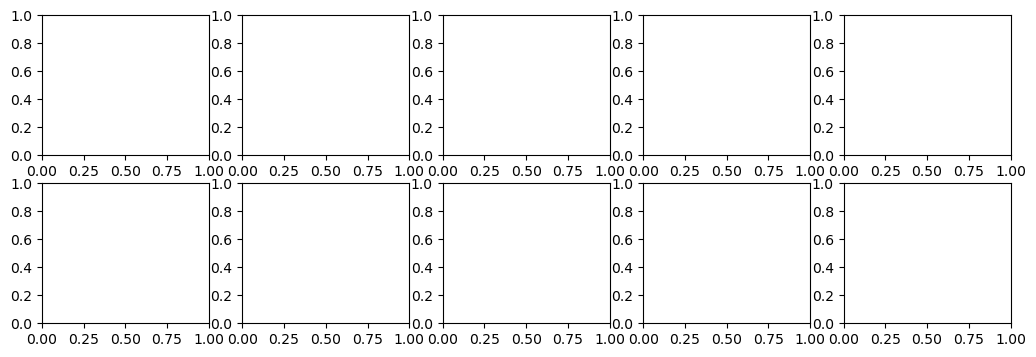

In [25]:
def show_examples(ncols = 6):
    fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(ncols*2.5, 4))
    for i in range(ncols):
        directory = random.choice(directories)
        files = os.listdir(DIR_ORIGIN + directory)
        file = random.choice(files)
        img1 = cv2.imread(DIR_ORIGIN + directory + "/" + file)
        img2 = ben_preprocess(DIR_ORIGIN + directory + "/" + file)
        ax[0, i].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        ax[1, i].imshow(img2, cmap="gray")
        file_path = directory + "/" + file
        ax[0, i].set_title(f"Original\n{file_path}", fontsize=8)
        ax[1, i].set_title("Preprocessed", fontsize=8)
        ax[0, i].axis("off")
        ax[1, i].axis("off")
    plt.show()
    
show_examples(5)